# Variational AutoEncoder Code
This notebook is an implementation of a variational auto-encoder which was taken from https://blog.lancedb.com/training-a-variational-autoencoder-from-scratch-with-the-lance-file-format/


In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import io

from PIL import Image
from tqdm import tqdm


from matplotlib import pyplot as plt
import numpy as np
import requests
import tarfile
import os
import time

import pyarrow as pa
import lance


### Variational Autoencoder Configuration Breakdown
BATCH_SIZE:
- The number of samples processed together in one forward/backward pass before updating weights

IN_RESOLUTION:
- Input image resolution (width & height)

IN_CHANNELS: 
- Number of channels in the input
-- For RGB images->3 channels
-- For greyscale->1 channel

NUM_EPOCHS:
- Number of full passes through the dataset during training
- Higher epoch -> more opportunities for the model to converge

LEARNING_RATE: 
- Step size used by the optimiser to adjust wieghts
- Smaller -> more stable training but slower
- Larger -> faster, but may overshoot

HIDDEN_DIMS: 
- Defines the number of feature maps in each convolutional layer of the encoder/decoder
- Controls capacity & compression power. eg:
Layer 1: 64 filters
Layer 2: 128 filters
Layer 3: 256 filters
Layer 4: 512 filters

LATENT_DIM_SIZE: 
- Size of the latent space (bottleneck vector)
- size may depend on the image training data size

In [ ]:
training_filepath = "cat-spectrograms-2/cat-spectrograms-2_train.lance/"
# Only want the top level path of training_filepath
vae_config = {
    "BATCH_SIZE": 40,
    "IN_RESOLUTION": 256,
    "IN_CHANNELS": 3,
    "NUM_EPOCHS": 300,
    "LEARNING_RATE": 1e-4,
    "HIDDEN_DIMS":[256, 512, 1024, 2048],
    "LATENT_DIM_SIZE": 256,
}

Training filepath: cat-spectrograms-1/


### Utility function to visualise generated data.

In [24]:
def draw_image_grid(samples, save_image = False, path = None, outfile_name = "out", epoch = None):
    images = samples[:4]
    images = (images * 0.5) + 0.5  # Unnormalize the images to [0, 1] range
    grid_img = torchvision.utils.make_grid(images, nrow=2)
    plt.figure(figsize=(5, 5))
    plt.imshow(grid_img.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    plt.axis('off')
    if save_image and path is not None:
        filename = outfile_name + "_epoch_" + str(epoch) + ".png" if epoch is not None else outfile_name + ".png"
        full_path = os.path.join(path, filename)
        # Create the directory if it doesn't exist
        os.makedirs(path, exist_ok=True)

        # Save the figure to the specified path and name
        plt.savefig(full_path, dpi=500, bbox_inches='tight', pad_inches=0, transparent=True)
    plt.show()



def draw_image(samples, save_image = False, path = None, outfile_name = "out", epoch = None):
# Select the first image (or any index you want)
    image = samples[0]

    # Unnormalize from [-1, 1] to [0, 1]
    image = (image * 0.5) + 0.5

    # Convert tensor to numpy and permute from (C, H, W) → (H, W, C)
    image = image.permute(1, 2, 0).detach().cpu().numpy()

    # Display the image
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis('off')
    
    if save_image and path is not None:
        filename = outfile_name + "_epoch_" + str(epoch) + ".png" if epoch is not None else outfile_name + ".png"
        full_path = os.path.join(path, filename)
        # Create the directory if it doesn't exist
        os.makedirs(path, exist_ok=True)

        # Save the figure to the specified path and name
        plt.savefig(full_path, dpi=500, bbox_inches='tight', pad_inches=0, transparent=True)
    plt.show()

def plot_loss(loss_array):
    plt.figure(figsize=(10, 5))
    plt.plot(loss_array, label='Loss')
    plt.grid()
    plt.xlim([0, vae_config["NUM_EPOCHS"]-1])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')


def plot_loss_multiple(loss_arrays, labels):
    plt.figure(figsize=(10, 5))
    for loss_array, label in zip(loss_arrays, labels):
        plt.plot(loss_array, label=label)
    plt.grid()
    plt.xlim([0, vae_config["NUM_EPOCHS"]-1])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

def save_loss_array(loss_array, folder="output_data", filename="loss_array.npy"):
    # Create the directory if it doesn't exist
    os.makedirs(folder, exist_ok=True)
    file_path = os.path.join(folder, filename)
    np.save(file_path, loss_array)

In [4]:
class CustomImageDataset(data.Dataset):
    def __init__(self, classes, lance_dataset, transform=None):
        self.classes = classes
        self.ds = lance.dataset(lance_dataset)
        self.transform = transform

    def __len__(self):
        return self.ds.count_rows()

    def __getitem__(self, idx):
        raw_data = self.ds.take([idx], columns=['image', 'label']).to_pydict()
        img_data, label = raw_data['image'][0], raw_data['label'][0]

        img = Image.open(io.BytesIO(img_data))

        # Convert grayscale images to RGB
        if img.mode != 'RGB':
            img = img.convert('RGB')

        if self.transform:
            img = self.transform(img)

        label = self.classes.index(label)
        return img, label

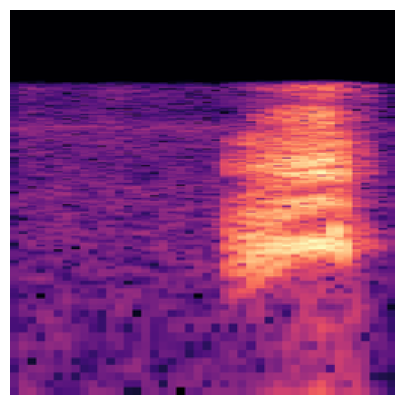

In [ ]:
train_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # -1 to 1
    ]
)
classes = ('cat')

lance_train_dataset = CustomImageDataset(
    classes,
    #UPDATE PATH BASED ON DATASET
    training_filepath,
    transform=train_transform
)

lance_train_loader = torch.utils.data.DataLoader(
    lance_train_dataset,
    batch_size=vae_config["BATCH_SIZE"],
    shuffle=True
)

images, _ = next(iter(lance_train_loader))
draw_image(images, save_image = False, epoch=10, path = "output_images", outfile_name = "training_Images")

### VAE Class Defintion 

In [6]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(vae_config["IN_CHANNELS"], 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )

        self.fc_mu = nn.Linear(128*32*32, vae_config["LATENT_DIM_SIZE"])
        self.fc_logvar = nn.Linear(128*32*32, vae_config["LATENT_DIM_SIZE"])

        # Decoder
        self.decoder_input = nn.Linear(vae_config["LATENT_DIM_SIZE"], 128*32*32)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, vae_config["IN_CHANNELS"], kernel_size=4, stride=2, padding=1),
            nn.Tanh()  # Output values in range [-1, 1]
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # change forward - add noise
        x = self.encoder(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        z = self.decoder_input(z)
        z = z.view(-1, 128, 32, 32)
        return self.decoder(z), mu, logvar

    def sample(self, num_samples):
        z = torch.randn(num_samples, vae_config["LATENT_DIM_SIZE"]).to(device)
        return self.decoder(self.decoder_input(z).view(-1, 128, 32, 32))

### Training the data

In [ ]:
device = "cpu" #change to "cuda" if you have an NVIDIA CPU

# Loss Function
def vae_loss(recon_x, x, mu, logvar):
    # change input
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

# Initialize model, optimizer
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=vae_config["LEARNING_RATE"])
# Define loss array and reference image to see reconstruction quality
loss_array = np.array([])
train_image, _ = next(iter(lance_train_loader))

Epoch 1/10: 100%|██████████| 8/8 [00:23<00:00,  2.91s/it, Loss=2.29e+6]


Epoch [1/10] Average Loss: 86016.3019


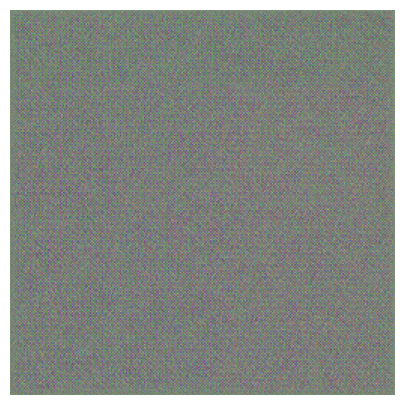

Epoch 2/10: 100%|██████████| 8/8 [00:21<00:00,  2.70s/it, Loss=1.86e+6]


Epoch [2/10] Average Loss: 73875.5755


Epoch 3/10: 100%|██████████| 8/8 [00:21<00:00,  2.67s/it, Loss=1.52e+6]


Epoch [3/10] Average Loss: 59446.4980


Epoch 4/10: 100%|██████████| 8/8 [00:21<00:00,  2.72s/it, Loss=1.06e+6]


Epoch [4/10] Average Loss: 44118.9586


Epoch 5/10: 100%|██████████| 8/8 [00:23<00:00,  2.98s/it, Loss=7.08e+5]


Epoch [5/10] Average Loss: 30817.8143


Epoch 6/10: 100%|██████████| 8/8 [00:22<00:00,  2.78s/it, Loss=6.02e+5]


Epoch [6/10] Average Loss: 23518.1449


Epoch 7/10: 100%|██████████| 8/8 [00:20<00:00,  2.61s/it, Loss=4.96e+5]


Epoch [7/10] Average Loss: 19409.5933


Epoch 8/10: 100%|██████████| 8/8 [00:18<00:00,  2.36s/it, Loss=4.46e+5]


Epoch [8/10] Average Loss: 16243.3387


Epoch 9/10: 100%|██████████| 8/8 [00:20<00:00,  2.53s/it, Loss=3.61e+5]


Epoch [9/10] Average Loss: 14120.9471


Epoch 10/10: 100%|██████████| 8/8 [00:17<00:00,  2.24s/it, Loss=3.2e+5] 

Epoch [10/10] Average Loss: 12662.6694


Text(0, 0.5, 'Loss')

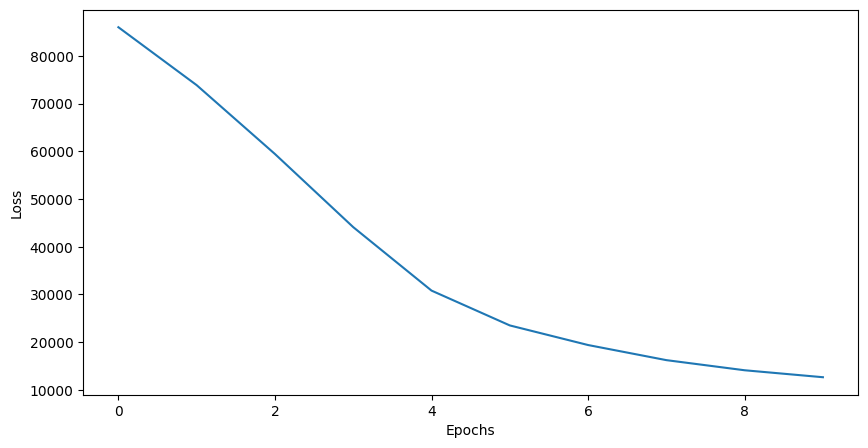

In [ ]:
# Training Loop
for epoch in range(vae_config["NUM_EPOCHS"]):
    model.train()
    train_loss = 0

    # Use tqdm for the progress bar
    pbar = tqdm(enumerate(lance_train_loader), total=len(lance_train_loader), desc=f'Epoch {epoch+1}/{vae_config["NUM_EPOCHS"]}')

    for batch_idx, (data, _) in pbar:
        data = data.to(device)

        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        # Update tqdm description with current loss
        pbar.set_postfix({'Loss': loss.item()})

    avg_loss = train_loss / len(lance_train_loader.dataset)
    loss_array = np.append(loss_array, avg_loss)
    print(f'Epoch [{epoch + 1}/{vae_config["NUM_EPOCHS"]}] Average Loss: {avg_loss:.4f}')

    # show and display a sample of the reconstructed images
    if epoch % 10 == 0:
        with torch.no_grad():
            recon_image, _, _ = model(train_image.to(device))
            draw_image(recon_image.cpu(), save_image = True, epoch=epoch, path = "training_images", outfile_name = "log_spec_1")


### Save loss array to .npy

In [ ]:
training_filepath = training_filepath.split('/')[0]
# Save the loss array to a .npy file in output_data folder
save_loss_array(loss_array, folder="output_data", filename= training_filepath +".npy")

[86016.30194805 73875.57548701 59446.49797078 44118.9586039
 30817.8143263  23518.14488636 19409.59334416 16243.33867695
 14120.9471388  12662.66943994]


### Plotting the loss function of the training

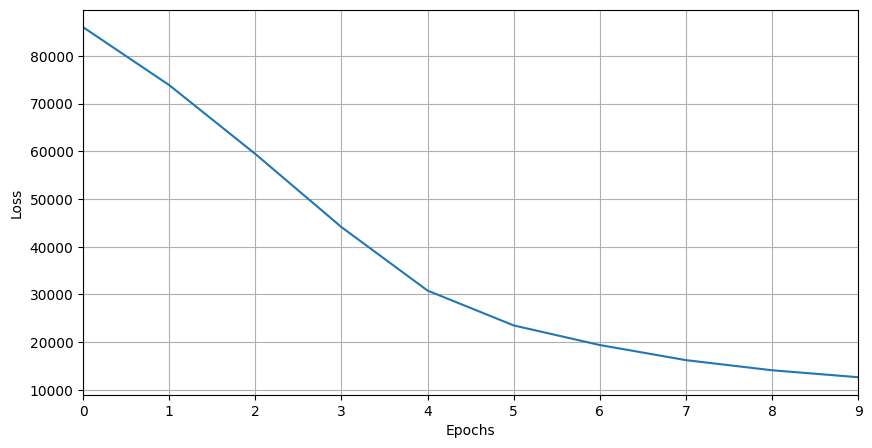

In [21]:
plot_loss(loss_array)

### The Reconstructed Images

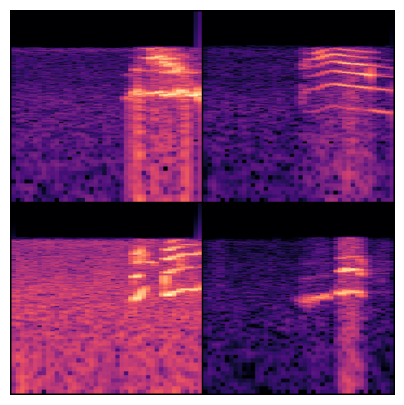

In [28]:
images, _ = next(iter(lance_train_loader))
draw_image_grid(images)

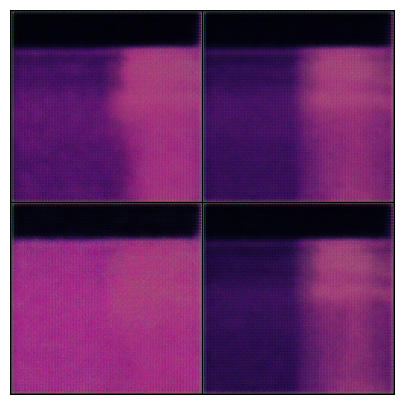

In [29]:
with torch.no_grad():
    recon_images, _, _ = model(images.to(device))
draw_image_grid(recon_images.cpu())

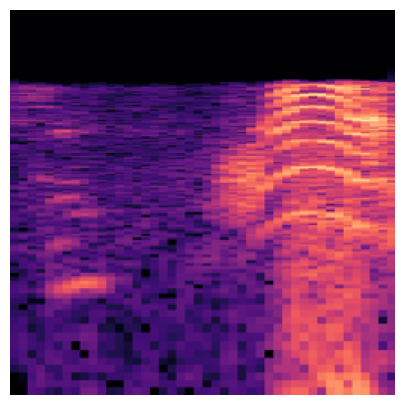

In [30]:
image, _ = next(iter(lance_train_loader))
draw_image(image, save_image=True, path="reconstructedImages", outfile_name="original_5")

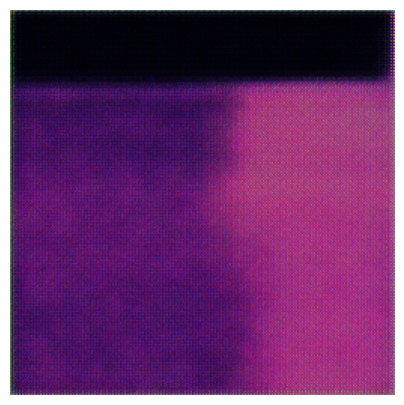

In [31]:
with torch.no_grad():
    recon_image, _, _ = model(image.to(device))
draw_image(recon_image.cpu(), save_image=True, path="reconstructedImages", outfile_name="recon_5")